# Head

In [3]:
import sys
sys.path.append("projects/periodical-clustering")

from utils import get_data_dir

In [39]:
import os
import json
from tqdm import tqdm
import pickle

import pandas as pd
import numpy as np
from scipy import sparse

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

import seaborn as sns
import matplotlib.pyplot as plt

class ProgressHashingVectorizer(HashingVectorizer):
    """带进度条的HashingVectorizer"""
    
    def transform(self, X):
        """重写transform方法以添加进度条"""
        # 如果输入是列表或类似列表的对象
        if hasattr(X, '__len__'):
            self.n_samples_ = len(X)
            
            # 创建包装器函数为文档添加进度条
            wrapped_X = tqdm(X, desc="Vectorizing documents", total=self.n_samples_)
            return super().transform(wrapped_X)
        
        # 如果输入不是列表类型（可能是生成器），则不添加进度条
        return super().transform(X)

class DocumentClassifier:
    def __init__(self, data_dir: str, model):
        self.data_dir = data_dir
        self.model = model
        self.vectorizer = None
        self.df = None
        self.train_df = None
        self.test_df = None
        self.X_train = None
        self.X_test = None
        self.label_to_method = {'kmeans_label': 'Periodical2Vec+$k$-means',
                                 # 'skm_label': 'Periodical2Vec+Sperical $k$-means',
                                 # 'movmf_label': 'Periodical2Vec+movMF',
                                 'bert_kmeans_label': 'BERT+$k$-means',
                                 'n2v_kmeans_label': 'Node2Vec+$k$-means',
                                 'cm_kmeans_label': 'Citation Matrix+$k$-means',
                                 # 'gnn_kmeans_label': 'GNN+$k$-means',
                                 'scopus_label': 'Scopus'}
        self.n_splits = 10
        self.roc_results = None
        # 缓存文件路径
        self.cache_dir = os.path.join(data_dir, '2010s','cache')
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def load_and_prepare_data(self, load_raw_abstract: bool=True) -> None:
        """加载abstracts和标签数据，构建DataFrame"""
        # 使用上下文管理器和生成器模式加载abstracts
        abstracts_path = os.path.join(self.data_dir, '2010s/classification_tasks/abstracts/paper_abstracts.json')
        
        # 使用生成器表达式优化内存使用
        print("Loading abstracts...")
        
        def abstract_generator(load_raw_abstract: True):
            with open(abstracts_path, 'r') as f:
                for line in tqdm(f, desc='Loading abstracts'):
                    try:
                        paper_data = json.loads(line.strip())
                        pid = str(paper_data['PaperID'])
                        if load_raw_abstract:
                            abstract = paper_data.get('abstract', '')
                            yield {'PaperID': pid, 'abstract': abstract}
                        else: # skip abstracts loading. No much speedup. Mainly for memory saving.
                            yield {'PaperID': pid}
                    except (json.JSONDecodeError, KeyError) as e:
                        print(f"Error parsing JSON: {e}")
                        continue
        
        # 创建DataFrame
        self.df = pd.DataFrame(abstract_generator(load_raw_abstract))
        self.df.set_index('PaperID', inplace=True)
        print(f"Initial DataFrame with {len(self.df)} abstracts")
        
        # 标签
        labels_dir = os.path.join(self.data_dir, '2010s/classification_tasks/labels')
        labels_df = {}
        
        print("Processing label files...")
        for label_name in tqdm(self.label_to_method.keys(), desc='Labels processing'):
            label_file = f"{label_name}.json"
            label_path = os.path.join(labels_dir, label_file)
            with open(label_path, 'r') as f:
                label_dict = json.load(f)
            labels_df[label_name] = {str(k): v for k, v in label_dict.items()} # ~45s for loading one label type
        labels_df = pd.DataFrame(labels_df)
        labels_df.index.name = 'PaperID'

        print(f"Labels DataFrame with {len(labels_df)} labels")
        print("Merging abstracts and labels...")
        self.df = self.df.join(labels_df, how='inner')
        print(f"Final dataset: {len(self.df)} valid samples")
    
    def prepare_features(self, df: pd.DataFrame, cache_type: str = None, test_ratio: float=0.2) -> np.ndarray:
        """集中处理文本特征提取逻辑，使用HashingVectorizer，加入缓存机制"""
        # 生成缓存文件路径
        cache_prefix = f"{cache_type}_{test_ratio}_hashing"
        features_cache_path = os.path.join(self.cache_dir, f"{cache_prefix}_features.npz")
        
        # 检查是否存在缓存的特征
        if os.path.exists(features_cache_path):
            print(f"Loading cached Hashing features for {cache_type}...")
            
            # 直接加载稀疏矩阵
            X = sparse.load_npz(features_cache_path)
            return X
        
        # 如果没有缓存，则计算特征
        if self.vectorizer is None:
            print("Creating and applying HashingVectorizer...")
            self.vectorizer = ProgressHashingVectorizer(
                n_features=2**20,
                alternate_sign=False,
                stop_words='english',
                norm='l2',)
            X = self.vectorizer.fit_transform(df['abstract'])
        else:
            print("Applying existing HashingVectorizer...")
            X = self.vectorizer.transform(df['abstract'])
        
        # 直接使用sparse.save_npz保存稀疏矩阵，而不是使用np.savez_compressed
        print(f"Caching Hashing features to {features_cache_path}")
        sparse.save_npz(features_cache_path, X)
        
        return X

    def train_model(self, label_name: str, test_ratio: float = 0.2):
        """训练特定标签的分类模型"""
        print(self.model)
        if self.df is None:
            raise ValueError("Dataset not loaded. Call load_and_prepare_data first.")
        
        # 准备数据集
        if self.train_df is None and self.test_df is None:
            print("Splitting dataset into train and test sets...")
            self.train_df, self.test_df = train_test_split(
                self.df, test_size=test_ratio, random_state=42)
            print(f"Train set: {len(self.train_df)} samples")
            print(f"Test set: {len(self.test_df)} samples")
        else:
            print("Using existing train and test sets")
        # 特征提取，缓存训练特征
        if self.X_train is None:
            print("Preparing features for training data...")
            self.X_train = self.prepare_features(self.train_df, "train", test_ratio)
        else:
            print("Using existing training features")
        print(f"Features shape: {self.X_train.shape}")

        # 训练模型
        print(f"Training model for label: {label_name}")
        self.model.fit(self.X_train, self.train_df[label_name])
        print("Model trained successfully")

        return self.model

    def evaluate_model(self, label_name: str, test_ratio: float = 0.2):
        """评估模型性能，并与DummyClassifier进行对比"""
        print(self.model)
        if self.X_test is None:
            print("Preparing features for test data...")
            self.X_test = self.prepare_features(self.test_df, "test", test_ratio)
        
        # 性能评估
        print("\nEvaluating model performance:")
        print("--------------------------------")
        y_true = self.test_df[label_name]
        y_pred = self.model.predict(self.X_test)

        print(classification_report(y_true, y_pred, digits=4))
        
        model_metrics = precision_recall_fscore_support(
            y_true, y_pred, average='macro'
        )
        model_precision, model_recall, model_f1, _ = model_metrics

        # 基准模型评估
        print("\nEvaluating baseline model (Stratified Random):")
        print("------------------------------------------")
        baseline_model = DummyClassifier(strategy='stratified', random_state=42)
        baseline_model.fit(self.X_train, self.train_df[label_name])
        baseline_pred = baseline_model.predict(self.X_test)
        
        baseline_metrics = precision_recall_fscore_support(
            y_true, baseline_pred, average='macro'
        )
        baseline_precision, baseline_recall, baseline_f1, _ = baseline_metrics
        
        # 性能改进报告
        print("\nImprovement over baseline (macro metrics):")
        print("----------------------------------------")
        metrics_diff = {
            "Precision": model_precision - baseline_precision,
            "Recall": model_recall - baseline_recall,
            "F1": model_f1 - baseline_f1
        }
        for metric, diff in metrics_diff.items():
            print(f"{metric} difference: {diff:.4f}")

        # 绘制混淆矩阵
        self._plot_confusion_matrices(y_true, y_pred, baseline_pred, label_name)

    def _plot_confusion_matrices(self, y_true, y_pred, baseline_pred, label_name):
        """封装混淆矩阵绘制逻辑"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        cbar_ax = fig.add_axes([0.9, 0.06, 0.02, 0.88])
        
        # 模型混淆矩阵
        cm_model = confusion_matrix(y_true, y_pred, normalize='true')
        sns.heatmap(cm_model, annot=False, cmap='Blues', vmin=0, vmax=1, ax=ax1, cbar=False)
        ax1.set_title(f"Trained classifier")
        ax1.set_xlabel('Prediction')
        ax1.set_ylabel('Labels')
        
        # Baseline混淆矩阵
        cm_baseline = confusion_matrix(y_true, baseline_pred, normalize='true')
        sns.heatmap(cm_baseline, annot=False, cmap='Blues', vmin=0, vmax=1, ax=ax2, 
                cbar=True, cbar_ax=cbar_ax)
        ax2.set_title(f"Dummy classifier")
        ax2.set_xlabel('Prediction')
        ax2.set_ylabel('Labels')

        plt.tight_layout(rect=[0, 0, 0.9, 1])
        
        # 保存图像并显示
        output_path = os.path.join('/home/zqlyu2/projects/periodical-clustering/tasks/', 
                                   f'confusion_matrix_{label_name}.pdf')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Confusion matrix saved to {output_path}")

    def one_vs_rest(self, label_to_method: dict, test_ratio: float = 0.2, metric: str = 'roc'):
        """修改后的One-vs-Rest分类实现，单次实验"""
        print("Current model:", self.model)
        if self.df is None:
            print("Dataset not loaded. Call load_and_prepare_data first.")
            self.load_and_prepare_data()
        
        # 初始化结果存储
        self.results = {label: [] for label in label_to_method.keys()}
        
        # 准备数据集
        if self.train_df is None and self.test_df is None:
            print("Splitting dataset into train and test sets...")
            self.train_df, self.test_df = train_test_split(
                self.df, test_size=test_ratio, random_state=42)
            print(f"Train set: {len(self.train_df)} samples")
            print(f"Test set: {len(self.test_df)} samples")
        else:
            print("Using existing train and test sets")
        # 特征提取，缓存训练特征
        if self.X_train is None:
            print("Preparing features for training data...")
            self.X_train = self.prepare_features(self.train_df, "train", test_ratio)
        else:
            print("Using existing training features")
            print(f"Training features shape: {self.X_train.shape}")
        if self.X_test is None:
            print("Preparing features for test data...")
            self.X_test = self.prepare_features(self.test_df, "test", test_ratio)
        else:
            print("Using existing test features")
            print(f"Test features shape: {self.X_test.shape}")
        
        # 处理每个标签
        for label_column, method_name in label_to_method.items():
            print(f"\nProcessing {method_name} ({label_column})")
            unique_classes = sorted(self.df[label_column].unique())
            y_train = label_binarize(self.train_df[label_column], classes=unique_classes)
            y_test = label_binarize(self.test_df[label_column], classes=unique_classes)
            n_classes = y_train.shape[1]
            
            # 训练模型
            print("Training classifier...")
            classifier = OneVsRestClassifier(self.model, n_jobs=-1, verbose=1)
            classifier.fit(self.X_train, y_train)
            
            # 模型评估
            print(f"Computing {metric} and AUC...")
            y_score = classifier.predict_proba(self.X_test)
            if metric == 'roc':
                fpr, tpr, macro_auc = self._compute_roc_metrics(y_test, y_score, n_classes)
                # 存储结果
                self.results[label_column].append((fpr, tpr, macro_auc))
                print(f"{label_column}: Macro AUC = {macro_auc:.4f}")
            if metric == 'pr':
                recall, precision, macro_ap = self._compute_pr_metrics(y_test, y_score, n_classes)
                self.results[label_column].append((recall, precision, macro_ap))
                print(f"{label_column}: Macro AP = {macro_ap:.4f}")

        with open(os.path.join(self.data_dir, '2010s',  'classification_tasks',f'{metric}_results.pkl', 'wb')) as f:
            pickle.dump(self.results, f)
        print(f"{metric} results saved to {metric}_results.pkl")
        return self.results

    def _compute_roc_metrics(self, y_test, y_score, n_classes):
        """ROC计算"""
        fpr = dict()
        tpr = dict()
        
        # 对每个类别计算ROC
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        
        # 宏平均ROC曲线
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
        mean_tpr /= n_classes
        macro_auc = auc(all_fpr, mean_tpr)
        
        return all_fpr, mean_tpr, macro_auc
    
    def _compute_pr_metrics(self, y_test, y_score, n_classes):
        """计算PR曲线相关指标"""
        precision = dict()
        recall = dict()
        average_precision = dict()
        
        # 逐类别计算
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
        
        # 宏平均PR曲线
        all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
        mean_precision = np.zeros_like(all_recall)
        
        for i in range(n_classes):
            mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
        
        mean_precision /= n_classes
        macro_ap = np.mean(list(average_precision.values()))
        
        return all_recall, mean_precision, macro_ap

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


# Initialize

In [40]:
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

data_dir = get_data_dir()
# model = ComplementNB()
model = MultinomialNB()
# model = RandomForestClassifier(random_state=42, n_jobs=-1)
# model = SGDClassifier(loss='log_loss', early_stopping=True, random_state=42, 
#                       n_jobs=-1, verbose=0)

classifier = DocumentClassifier(data_dir, model)

data_dir:  /home/zqlyu2/projects/periodical-clustering/data


In [20]:
classifier.load_and_prepare_data()
classifier.df

Loading abstracts...


Loading abstracts: 23322430it [02:31, 154101.26it/s]


Initial DataFrame with 23322430 abstracts
Processing label files...


Labels processing: 100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [02:57<00:00, 44.37s/it]


Labels DataFrame with 29309324 labels
Merging abstracts and labels...
Final dataset: 23322430 valid samples


,abstract,kmeans_label,n2v_kmeans_label,cm_kmeans_label,scopus_label
PaperID,,,,,
2055207701,Abstract Lake Trout Salvelinus namaycush were ...,8,2,1,Agricultural and Biological Sciences
2055207717,Background\r\n\r\nThere is an increasing inter...,7,1,23,Medicine
2055207742,The primary goal of the current study was to e...,23,19,1,Social Sciences
2055207772,Introduction Les tumeurs du tronc cerebral r...,22,10,7,Medicine
2055207790,"Matrix metalloproteinase-13 (MMP-13), referred...",16,20,4,Immunology and Microbiology
...,...,...,...,...,...
2726882176,Objective \r\nThe purpose of this study was to...,17,3,21,Multidisciplinary
2726882179,Abstract The notion of Corporate Social Re...,24,22,1,Social Sciences
2726882219,"In this paper, the possibility of improving th...",14,4,6,Materials Science


In [41]:
classifier.load_and_prepare_data(load_raw_abstract=False) # load labels only
classifier.df

Loading abstracts...


Loading abstracts: 23322430it [02:12, 175421.82it/s]


Initial DataFrame with 23322430 abstracts
Processing label files...


Labels processing: 100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [03:36<00:00, 43.29s/it]


Labels DataFrame with 29309324 labels
Merging abstracts and labels...
Final dataset: 23322430 valid samples


,kmeans_label,bert_kmeans_label,n2v_kmeans_label,cm_kmeans_label,scopus_label
PaperID,,,,,
2055207701,8,13,2,1,Agricultural and Biological Sciences
2055207717,7,15,1,23,Medicine
2055207742,23,24,19,1,Social Sciences
2055207772,22,21,10,7,Medicine
2055207790,16,13,20,4,Immunology and Microbiology
...,...,...,...,...,...
2726882176,17,0,3,21,Multidisciplinary
2726882179,24,16,22,1,Social Sciences
2726882219,14,9,4,6,Materials Science


In [6]:
from sklearn.linear_model import LogisticRegression

# a chance to change model
classifier.model = LogisticRegression(random_state=42, verbose=0)

In [6]:
classifier.model

MultinomialNB()

# Multi-class classification

In [25]:
model = classifier.train_model('kmeans_label')

Using existing train and test sets
Using existing training features
Features shape: (18657944, 1048576)
Training model for label: kmeans_label
Model trained successfully



Evaluating model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.6233    0.3958    0.4842     49276
           1     0.5603    0.2206    0.3166     91678
           2     0.3926    0.0405    0.0733     51072
           3     0.7370    0.4737    0.5767    108366
           4     0.6589    0.5179    0.5799    261865
           5     0.4931    0.6859    0.5737    170742
           6     0.7116    0.6432    0.6757    322725
           7     0.5275    0.6985    0.6011    391338
           8     0.6551    0.6455    0.6502    151812
           9     0.5938    0.6089    0.6013    176703
          10     0.6923    0.0019    0.0038     61370
          11     0.6563    0.8415    0.7374    565791
          12     0.6640    0.6244    0.6436    193110
          13     0.4348    0.7498    0.5504     59157
          14     0.6407    0.5593    0.5972    301024
          15     0.7192    0.7268    0.7230    153022
          16     

/tmp/ipykernel_1909521/446922365.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


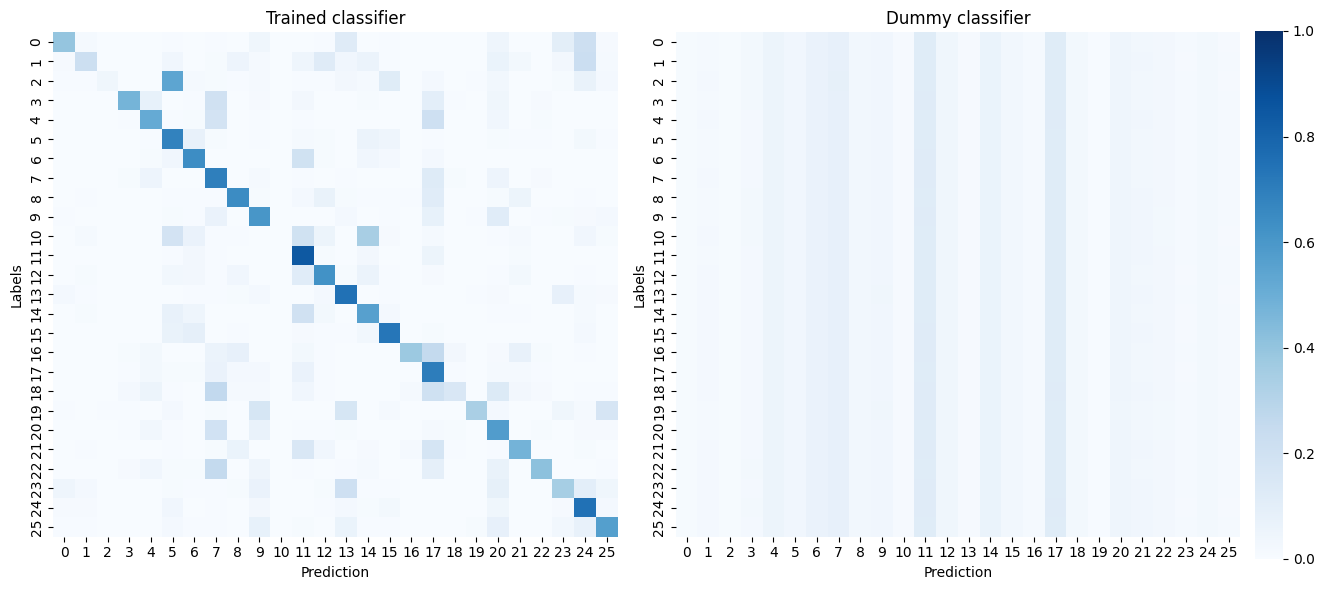

Confusion matrix saved to /home/zqlyu2/projects/periodical-clustering/tasks/confusion_matrix_kmeans_label.pdf


In [26]:
classifier.evaluate_model('kmeans_label')

In [9]:
model = classifier.train_model('n2v_kmeans_label')

Using existing train and test sets
Using existing training features
Features shape: (18657944, 1048576)
Training model for label: n2v_kmeans_label
Model trained successfully



Evaluating model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.1628    0.0185    0.0332     43697
           1     0.4148    0.6616    0.5099    244706
           2     0.5225    0.6144    0.5647    233948
           3     0.3199    0.1604    0.2137    356307
           4     0.6091    0.8110    0.6957    661279
           5     0.1837    0.0164    0.0302      8645
           6     0.4755    0.1991    0.2807     62781
           7     0.3418    0.0939    0.1473    244657
           8     0.5688    0.3854    0.4594     51745
           9     0.5659    0.5317    0.5483    168470
          10     0.3946    0.0095    0.0185    175568
          11     0.3604    0.0541    0.0941     16820
          12     0.5970    0.5483    0.5716    282398
          13     0.2546    0.0981    0.1416     83091
          14     0.3776    0.0300    0.0555    165877
          15     0.2533    0.2383    0.2456    114171
          16     

/tmp/ipykernel_1909521/446922365.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


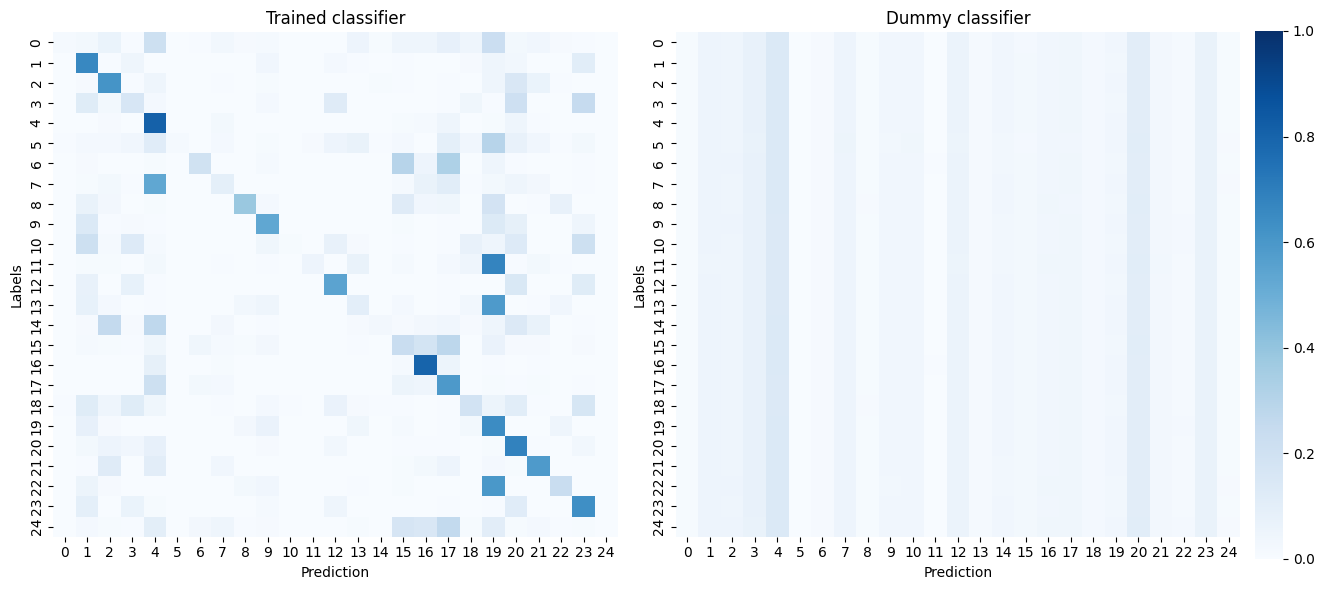

Confusion matrix saved to /home/zqlyu2/projects/periodical-clustering/tasks/confusion_matrix_n2v_kmeans_label.pdf


In [10]:
classifier.evaluate_model('n2v_kmeans_label')

In [11]:
model = classifier.train_model('cm_kmeans_label')

Using existing train and test sets
Using existing training features
Features shape: (18657944, 1048576)
Training model for label: cm_kmeans_label
Model trained successfully



Evaluating model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.5075    0.6321    0.5630    138108
           1     0.5608    0.5690    0.5648    998705
           2     0.0033    0.0003    0.0005      7236
           3     0.5999    0.4726    0.5287    139119
           4     0.6237    0.6053    0.6144    386303
           5     0.2861    0.0351    0.0624     32867
           6     0.5578    0.5352    0.5462    361072
           7     0.6704    0.3131    0.4269     77339
           8     0.6616    0.5887    0.6230    137356
           9     0.0698    0.0048    0.0090     10569
          10     0.6496    0.3870    0.4850     60314
          11     0.5030    0.1324    0.2097     49417
          12     0.0667    0.0018    0.0035      3878
          13     0.6667    0.4848    0.5614     92324
          14     0.5855    0.6136    0.5992    217639
          15     0.8197    0.3220    0.4624     26577
          16     

/tmp/ipykernel_1909521/446922365.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


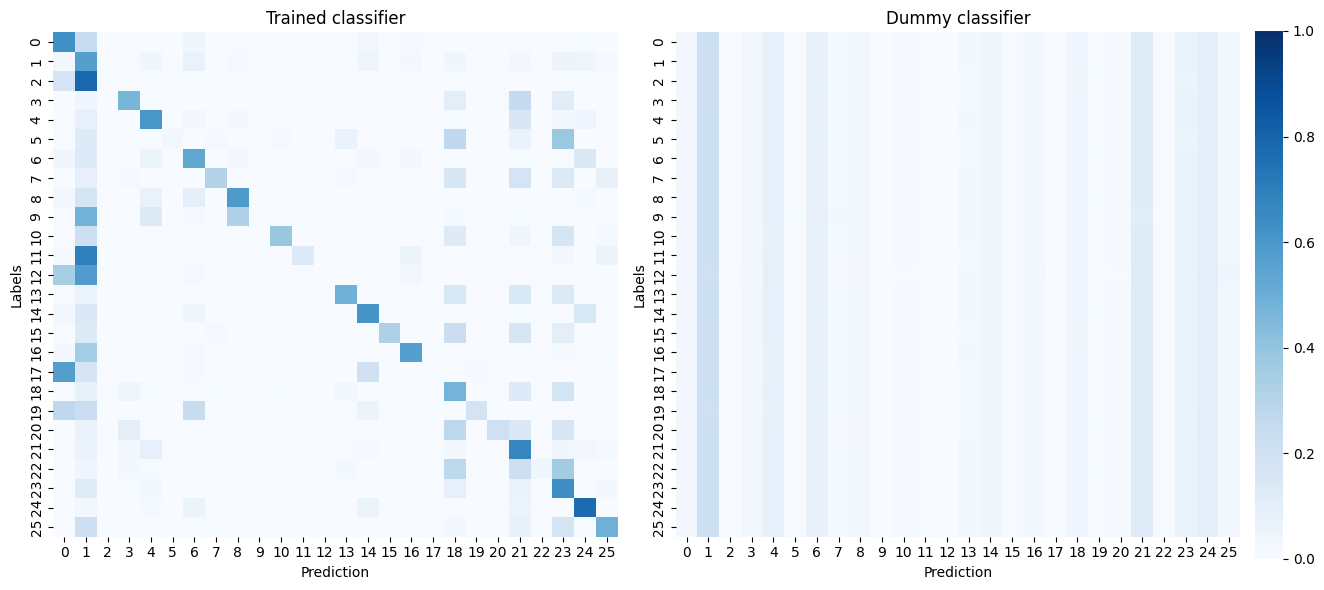

Confusion matrix saved to /home/zqlyu2/projects/periodical-clustering/tasks/confusion_matrix_cm_kmeans_label.pdf


In [12]:
classifier.evaluate_model('cm_kmeans_label')

In [13]:
model = classifier.train_model('scopus_label')

Using existing train and test sets
Using existing training features
Features shape: (18657944, 1048576)
Training model for label: scopus_label
Model trained successfully



Evaluating model performance:
--------------------------------
                                              precision    recall  f1-score   support

        Agricultural and Biological Sciences     0.6289    0.7160    0.6696    278826
                         Arts and Humanities     0.4543    0.4102    0.4311     81809
Biochemistry, Genetics and Molecular Biology     0.3950    0.5787    0.4695    252561
         Business, Management and Accounting     0.6721    0.2370    0.3505     61449
                        Chemical Engineering     0.4199    0.0479    0.0859     61802
                                   Chemistry     0.5730    0.6213    0.5962    273941
                            Computer Science     0.5122    0.4058    0.4528    112889
                           Decision Sciences     0.0000    0.0000    0.0000     10987
                                   Dentistry     0.7347    0.1061    0.1854     26883
                Earth and Planetary Sciences     0.7075    0.5549    0.6220

/tmp/ipykernel_1909521/446922365.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


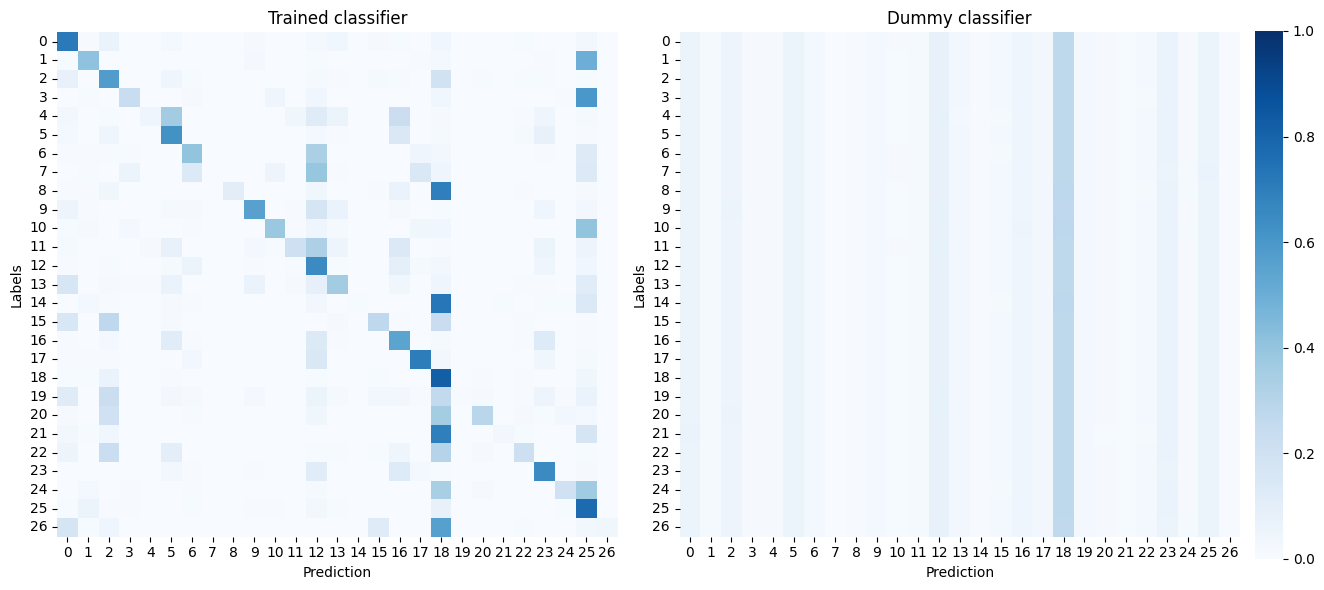

Confusion matrix saved to /home/zqlyu2/projects/periodical-clustering/tasks/confusion_matrix_scopus_label.pdf


In [14]:
classifier.evaluate_model('scopus_label')

In [5]:
model = classifier.train_model('bert_kmeans_label')

Splitting dataset into train and test sets...
Train set: 18657944 samples
Test set: 4664486 samples
Preparing features for training data...
Loading cached Hashing features for train...
Features shape: (18657944, 1048576)
Training model for label: bert_kmeans_label
Model trained successfully


Preparing features for test data...
Loading cached Hashing features for test...

Evaluating model performance:
--------------------------------
              precision    recall  f1-score   support

           0     0.5569    0.6177    0.5858    728801
           1     0.5442    0.0226    0.0434     65665
           2     0.5435    0.4782    0.5088     74127
           3     0.3567    0.5131    0.4208    106364
           4     0.5925    0.3464    0.4372     88211
           5     0.4043    0.5969    0.4821    119711
           6     0.6822    0.2213    0.3341    119395
           7     0.4539    0.3634    0.4036    146394
           8     0.6164    0.3491    0.4458     61244
           9     0.4972    0.5183    0.5075    270978
          10     0.4792    0.6789    0.5619    279804
          11     0.6075    0.5226    0.5619    106228
          12     0.5300    0.6967    0.6020    184131
          13     0.5663    0.4289    0.4881    164162
          14     0.4274    0.2633    0.3259  

/tmp/ipykernel_1909521/446922365.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


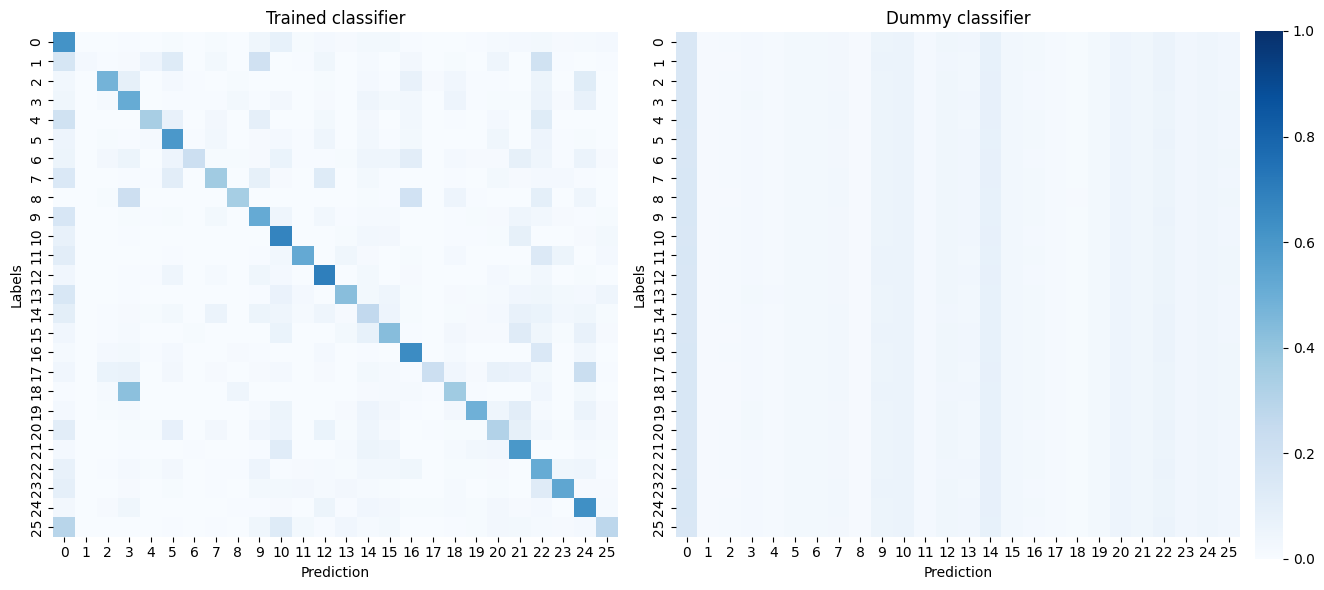

Confusion matrix saved to /home/zqlyu2/projects/periodical-clustering/tasks/confusion_matrix_bert_kmeans_label.pdf


In [6]:
classifier.evaluate_model('bert_kmeans_label')

# One-vs-rest clasiification

In [42]:
# indicate the label we want to analyze
label_to_method = {'kmeans_label': 'Periodical2Vec+$k$-means',
                   # 'skm_label': 'Periodical2Vec+Sperical $k$-means',
                   # 'movmf_label': 'Periodical2Vec+movMF',
                   
                   'bert_kmeans_label': 'BERT+$k$-means',
                   'n2v_kmeans_label': 'Node2Vec+$k$-means',
                   'cm_kmeans_label': 'Citation Matrix+$k$-means',
                   # 'gnn_kmeans_label': 'GNN+$k$-means',
                   'scopus_label': 'Scopus'
                   }

In [13]:
roc_results = classifier.one_vs_rest(label_to_method)

ComplementNB()
Using existing train and test sets
Using existing training features
Training features shape: (18657944, 1048576)
Using existing test features
Test features shape: (4664486, 1048576)

Processing Periodical2Vec+$k$-means (kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.3min finished


Computing ROC and AUC...
kmeans_label: Macro AUC = 0.9483

Processing Node2Vec+$k$-means (n2v_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   58.9s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.0min finished


Computing ROC and AUC...
n2v_kmeans_label: Macro AUC = 0.9059

Processing Citation Matrix+$k$-means (cm_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.0min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.1min finished


Computing ROC and AUC...
cm_kmeans_label: Macro AUC = 0.9426

Processing Scopus (scopus_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:  1.4min remaining:   58.4s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.4min finished


Computing ROC and AUC...
scopus_label: Macro AUC = 0.9379
ROC results saved to roc_results.pkl


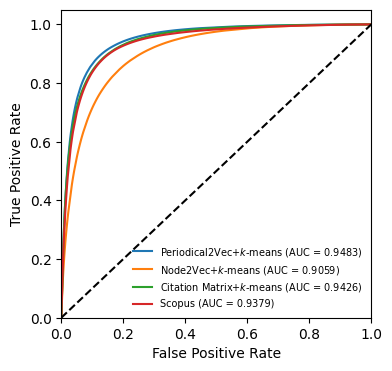

In [18]:
try:
    with open('/home/zqlyu2/projects/periodical-clustering/data/2010s/classification_tasks/roc_results.pkl', 'rb') as f:
        roc_results = pickle.load(f)
except FileNotFoundError:
    pass

fig = plt.figure(figsize=(4,4))

for label, results in roc_results.items():
    for fpr, tpr, auc_score in results:
        plt.plot(fpr, tpr, label=f"{classifier.label_to_method[label]} (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=7, frameon=False)

plt.show()
fig.savefig('/home/zqlyu2/projects/periodical-clustering/tasks/roc_curve.pdf', dpi=300, bbox_inches='tight')

In [43]:
pr_results = classifier.one_vs_rest(label_to_method, metric='pr')

Current model: MultinomialNB()
Splitting dataset into train and test sets...
Train set: 18657944 samples
Test set: 4664486 samples
Preparing features for training data...
Loading cached Hashing features for train...
Preparing features for test data...
Loading cached Hashing features for test...

Processing Periodical2Vec+$k$-means (kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.2min finished


Computing pr and AUC...
kmeans_label: Macro AP = 0.4093

Processing BERT+$k$-means (bert_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.1min finished


Computing pr and AUC...
bert_kmeans_label: Macro AP = 0.3422

Processing Node2Vec+$k$-means (n2v_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  1.1min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min finished


Computing pr and AUC...
n2v_kmeans_label: Macro AP = 0.3009

Processing Citation Matrix+$k$-means (cm_kmeans_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  26 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.2min finished


Computing pr and AUC...
cm_kmeans_label: Macro AP = 0.3349

Processing Scopus (scopus_label)
Training classifier...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:  1.1min remaining:   46.9s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.2min finished


Computing pr and AUC...
scopus_label: Macro AP = 0.3398
pr results saved to pr_results.pkl


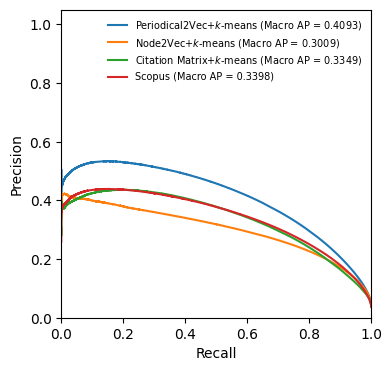

In [22]:
if pr_results is None:
    with open('/home/zqlyu2/projects/periodical-clustering/data/2010s/classification_tasks/pr_results.pkl', 'rb') as f:
        pr_results = pickle.load(f)

fig = plt.figure(figsize=(4,4))

for label, results in pr_results.items():
    for recall, precision, macro_ap in results:
        plt.plot(recall, precision, label=f"{classifier.label_to_method[label]} (Macro AP = {macro_ap:.4f})")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right', fontsize=7, frameon=False)

plt.show()
fig.savefig('/home/zqlyu2/projects/periodical-clustering/tasks/pr_curve.pdf', dpi=300, bbox_inches='tight')

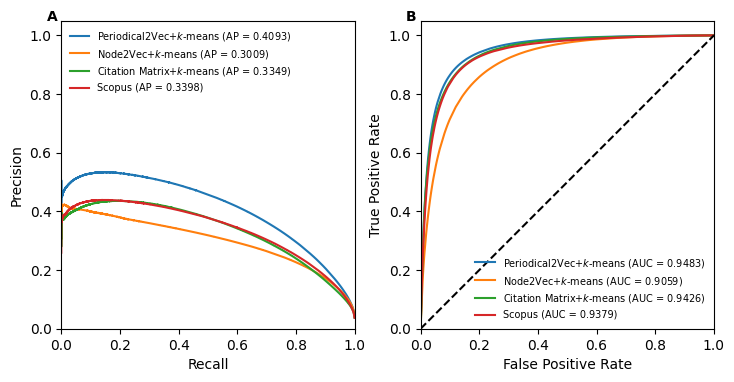

In [37]:
with open('/home/zqlyu2/projects/periodical-clustering/tasks/roc_results.pkl', 'rb') as f:
    roc_results = pickle.load(f)
with open('/home/zqlyu2/projects/periodical-clustering/tasks/pr_results.pkl', 'rb') as f:
    pr_results = pickle.load(f)

fig = plt.figure(figsize=(8.5,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for label, results in pr_results.items():
    for recall, precision, macro_ap in results:
        ax1.plot(recall, precision, label=f"{classifier.label_to_method[label]} (AP = {macro_ap:.4f})")
ax1.set_aspect('equal')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend(loc='upper left', fontsize=7, frameon=False)
ax1.text(-0.05, 1.05, 'A', weight='bold')

for label, results in roc_results.items():
    for fpr, tpr, auc_score in results:
        ax2.plot(fpr, tpr, label=f"{classifier.label_to_method[label]} (AUC = {auc_score:.4f})")
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_aspect('equal')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc='lower right', fontsize=7, frameon=False)
ax2.text(-0.05, 1.05, 'B', weight='bold')

plt.show()
fig.savefig('/home/zqlyu2/projects/periodical-clustering/tasks/PR_&_ROC_curve.pdf', dpi=300, bbox_inches='tight')